In [5]:
!pip install xarray

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for xarray from https://files.pythonhosted.org/packages/cc/21/c3a9d3017c131cea3c2967957b05448ffc81cafced239796bbbdc98073e4/xarray-2023.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.21 from https://files.pythonhosted.org/packages/71/3c/3b1981c6a1986adc9ee7db760c0c34ea5b14ac3da9ecfcf1ea2a4ec6c398/numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas>=1.4 from https://files.pythonhosted.org/packages/e3/59/35a2892bf09ded9c1bf3804461efe772836a5261ef5dfb4e264ce813ff99/pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 3.4 MB/s eta 0:00:003.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.

In [6]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

ModuleNotFoundError: No module named 'geopandas'

In [49]:
import netCDF4
import numpy as np
import glob

files = glob.glob('./DataExport/Lebanon-Snow-Cover-Data/*.nc')

# Initialize lists to hold data and time variables
latitude_list = []
longitude_list = []
time_list = []

# Loop through all files and read them
for file in files:
    with netCDF4.Dataset(file, 'r') as nc:
        # Assuming the variable is named 'temperature'; change as needed
        longitude = nc.variables['longitude'][:]
        latitude = nc.variables['latitude'][:]
        time = nc.variables['time'][:]  # Assuming a time variable exists

        latitude_list.append(latitude)
        longitude_list.append(longitude)
        time_list.append(time)

# Concatenate along the time dimension
concatenated_longitude = np.concatenate(longitude_list, axis=0)  # Adjust axis as needed
concatenated_latitude = np.concatenate(latitude_list, axis=0)  # Adjust axis as needed
concatenated_time = np.concatenate(time_list, axis=0)  # Adjust axis as needed



ds = {
    'longitude': concatenated_longitude,
    'latitude': concatenated_latitude,
    'time': concatenated_time
}


In [54]:
# Lazily load all HS netcdf 
ds = xr.open_mfdataset('./DataExport/Lebanon-Snow-Cover-Data/*.nc')

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'scipy']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [44]:
ds['time']

masked_array(data=[990562, 990586, 990610, ..., 932722, 932746, 932770],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [48]:
# Select period of interest 
endClimDate = '2022-12-30'
startClimDate = '1993-01-01'
print(ds)
datesSel = ds['time'].sel(time=slice(startClimDate, endClimDate)) # exceeds 1984-2014
# reduce UERRA dataset to these dates
dsSel = ds.sel(time=datesSel)
# plot mean snow depth
dsSel.sde.mean(dim=('longitude','latitude')).plot()
plt.title('Mean ERA 5 -LAND snow depth')

{'longitude': masked_array(data=[35.25, 35.35, 35.45, ..., 36.25, 36.35, 36.45],
             mask=False,
       fill_value=1e+20,
            dtype=float32), 'latitude': masked_array(data=[34.6, 34.5, 34.4, ..., 33.2, 33.1, 33. ],
             mask=False,
       fill_value=1e+20,
            dtype=float32), 'time': array([990562, 990586, 990610, ..., 932722, 932746, 932770], dtype=int32)}


AttributeError: 'numpy.ndarray' object has no attribute 'sel'

In [4]:
# Make X array with predictors
X = dsSel['sde'].values.reshape(datesSel.size,-1)
# remove nodata [TODO: APPLY MODIS AOI MASK]
ix = np.all(np.isnan(X),axis=0)
# This is the array of training data (snow depth of every cell)
X = X[:,~ix]

In [7]:
#highest Rating Model of 0.74 nash score
mod = pickle.load( open( "./Models/mod3-KNeighborsRegressor-LebanonCSV.pickle", "rb" ))
xmod = mod.predict(X)
lastPredDate = datesSel[-1]

In [8]:
f = 'LebanonCSV'
# create date and scf arrays from Modis csv
dfscf = pd.read_csv('Modis/{}.csv'.format(f), index_col=0, decimal='.')
doy = dfscf.index
dfdate = pd.DataFrame([pd.to_datetime(doy-1, unit='D', origin=str(y)) for y in dfscf.columns]).transpose()
dfdate.index = dfscf.index
dfdate.columns = dfscf.columns
dates = dfdate.transpose().stack(dropna=False)
scf = dfscf.transpose().stack(dropna=False)

In [12]:
# index of modis dates that will be used to complete the predicted series
ix = np.logical_and(dates > lastPredDate.values, dates < np.datetime64(endClimDate))

In [13]:
datesClim = pd.concat([
    pd.Series(datesSel), 
    pd.Series(dates[ix])]
    , axis=0, ignore_index=True)

scfClim = pd.concat([
    pd.Series(xmod),
    pd.Series(scf[ix])]
    , axis = 0, ignore_index=True)

In [14]:
def plotYear(year):
    fig = plt.figure(figsize=(12, 5), dpi=100)
    (ax1, ax2) = fig.subplots(ncols=2, sharey=True)

    ax1.plot(datesClim, scfClim)
    ax1.set_ylabel('Snow cover fraction')
    ax1.set_xlabel('Time')

    ax2.plot(datesClim, scfClim)
    ax2.set_xlabel('Time')

    ax1.set_title('{}-{}'.format(year,year+1))
    ax2.set_title('{}-{}'.format(year+1,year+2))
    ax1.set_xlim([date(year,11,1), date(year+1,7,1)])
    ax2.set_xlim([date(year+1,11,1), date(year+2,7,1)])
    ax1.set_ylim([0,1])
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


In [15]:
# convert dates to millis (POSIX) to match 'system:time_start' in earth engine
millis = pd.Series(datesClim, name='system:time_start')
millis = millis.apply(lambda x: x.replace(hour=0).timestamp()*1000 )

In [16]:
# concat scf
outdf = pd.concat([millis, pd.Series(scfClim, name='scf')], axis = 1)
outdf.set_index('system:time_start',inplace=True)
outdf.to_csv('./PredictedSCF/predictedLebanon.csv')

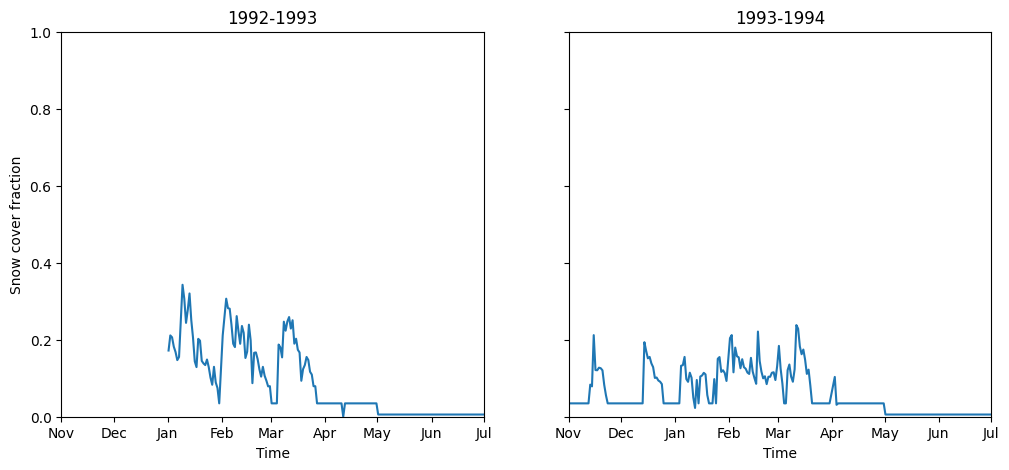

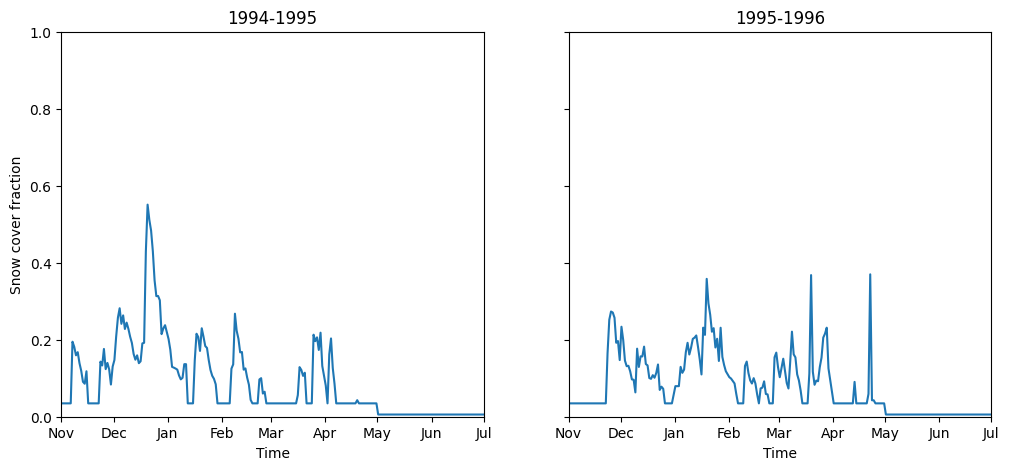

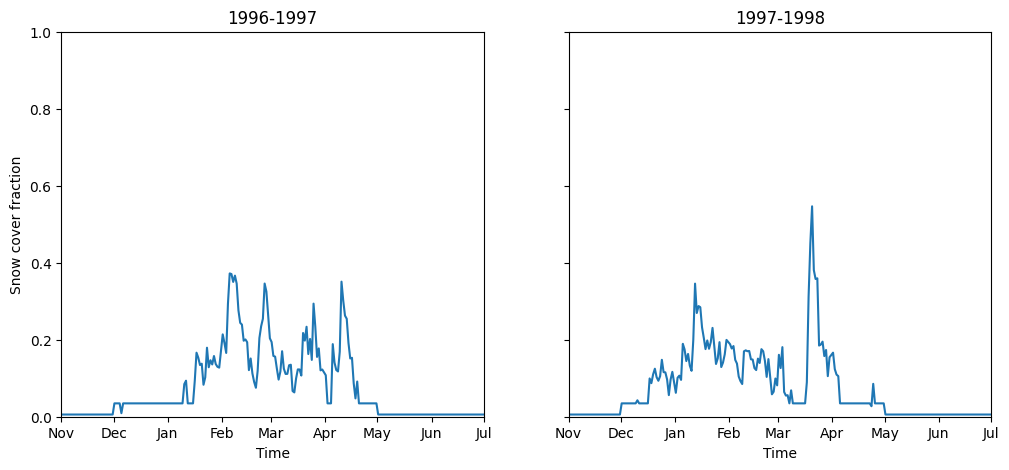

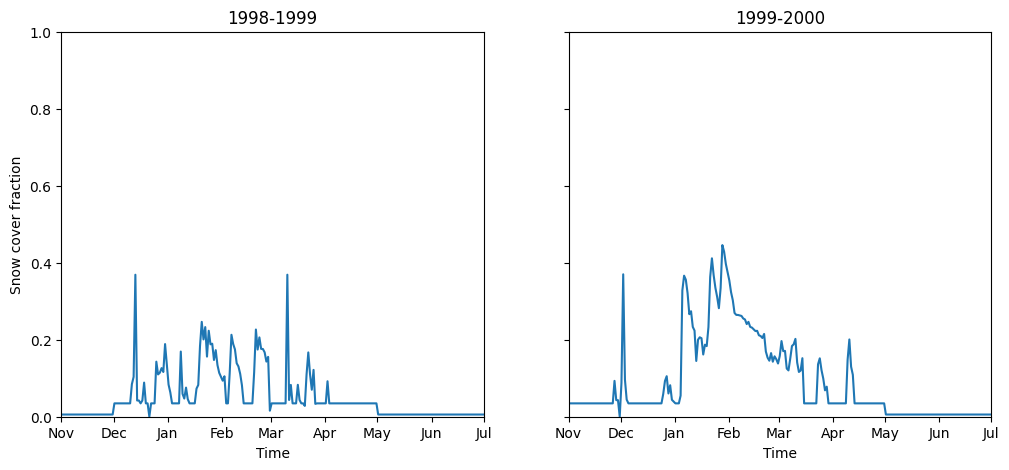

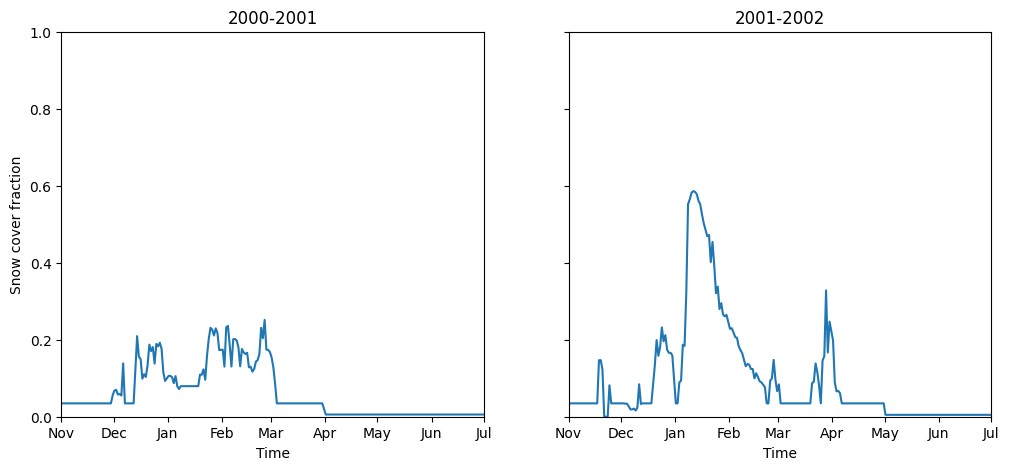

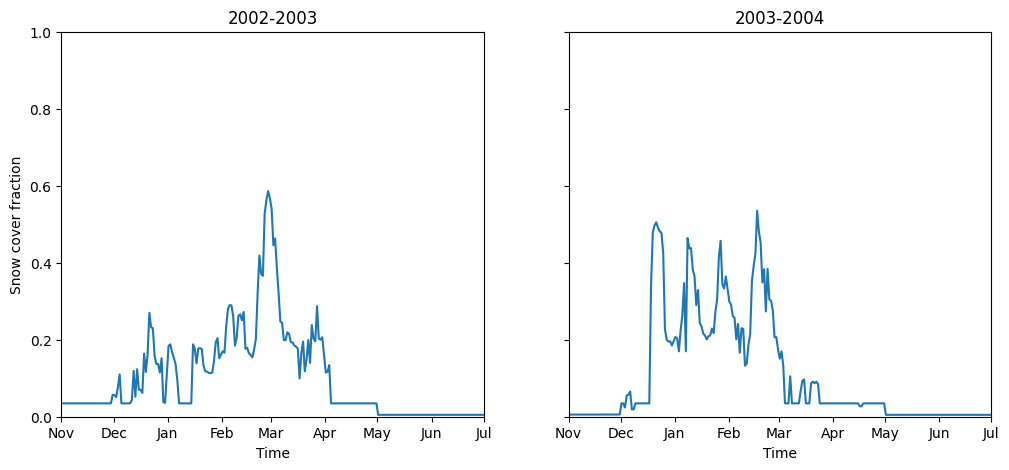

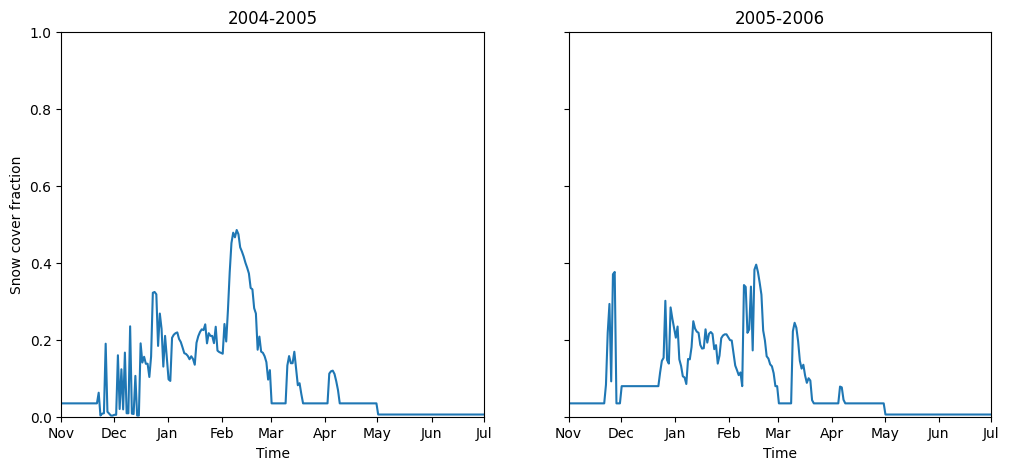

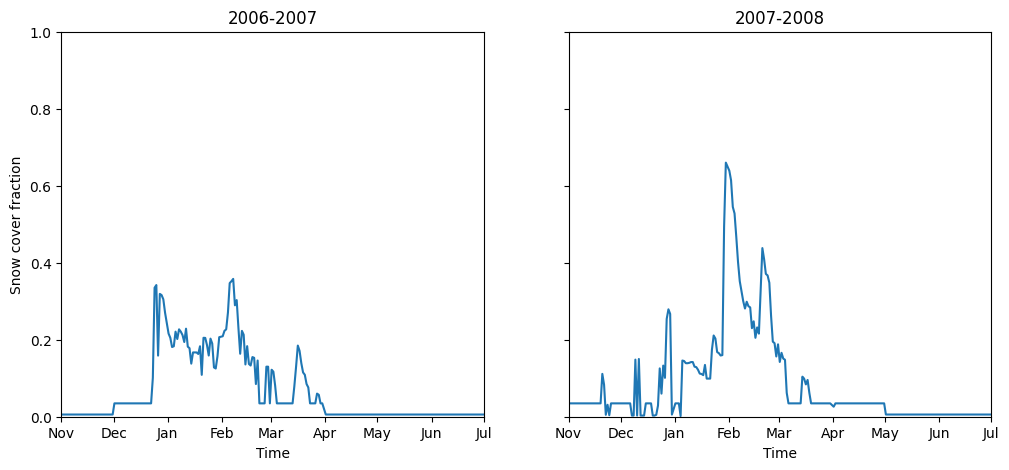

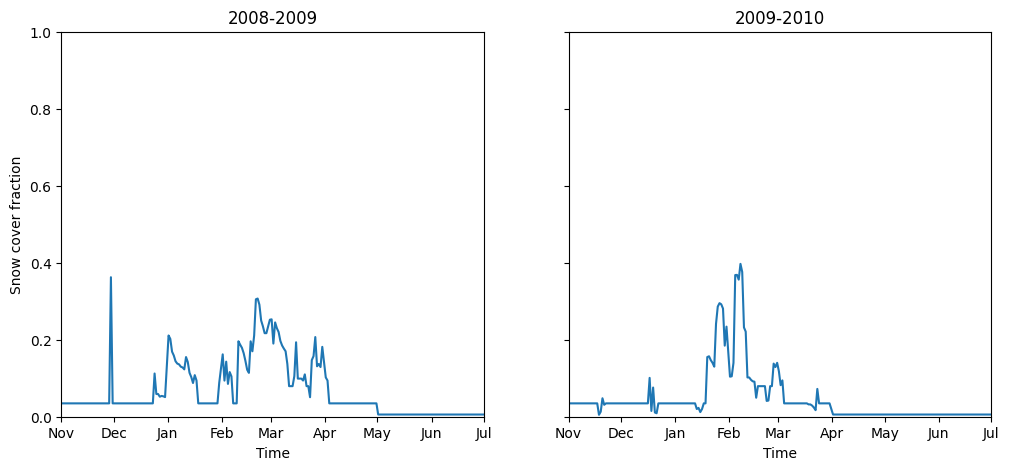

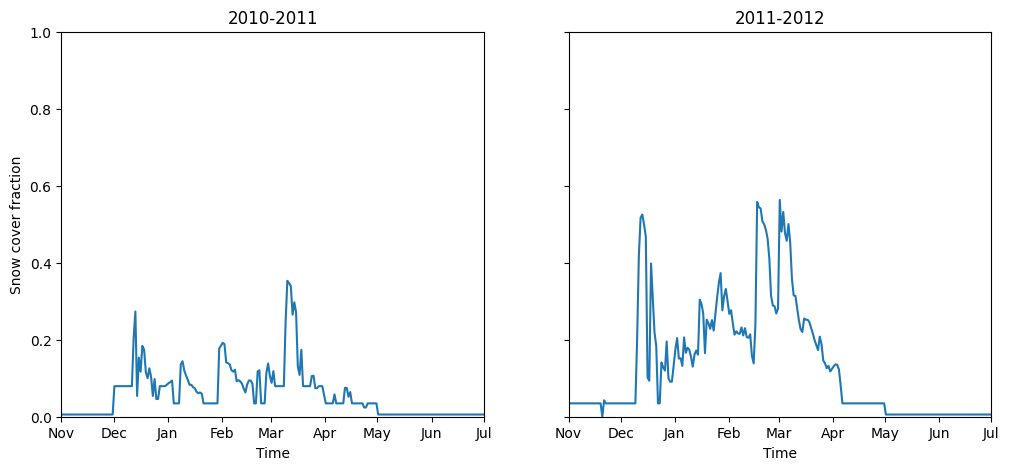

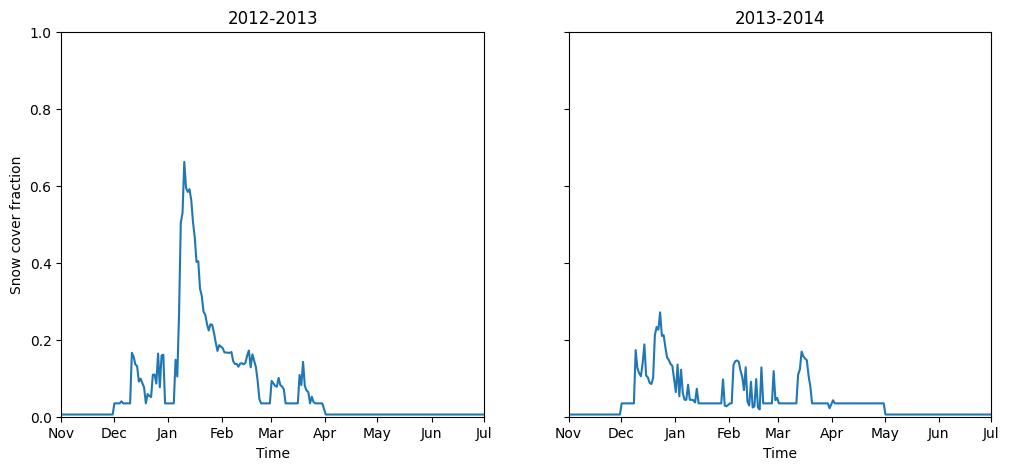

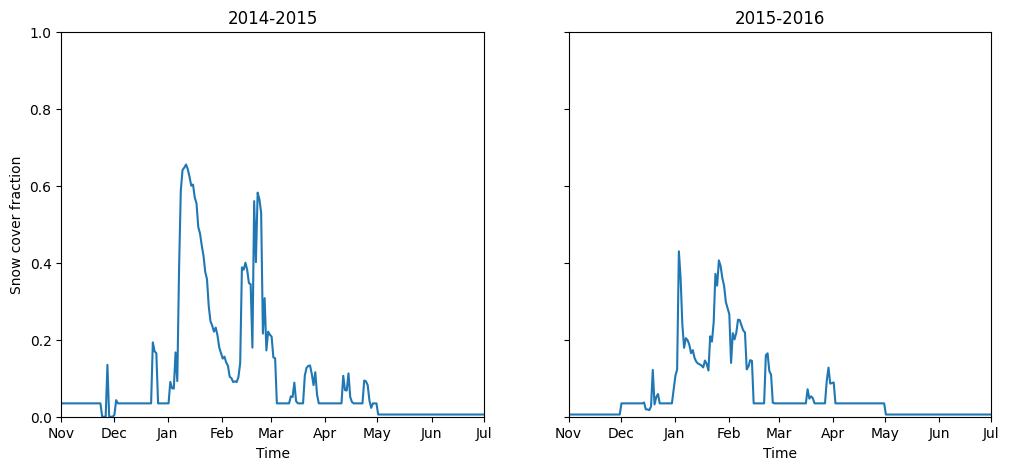

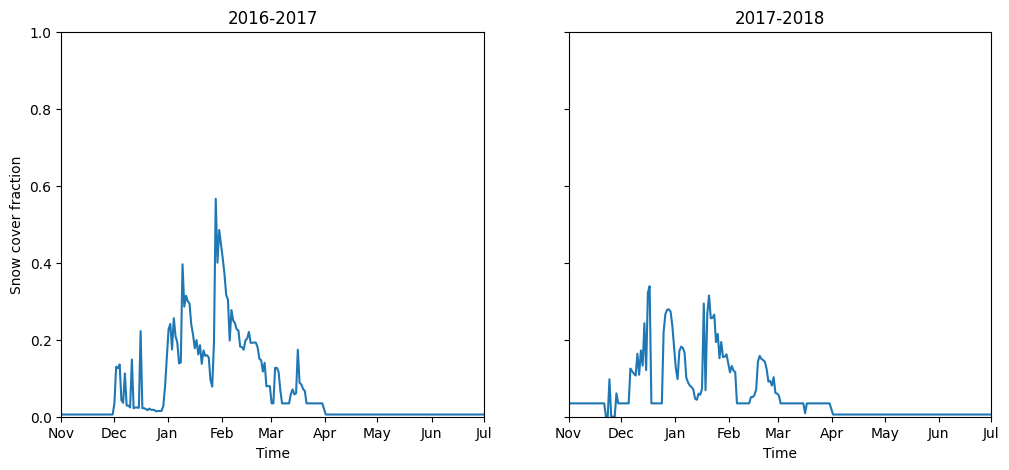

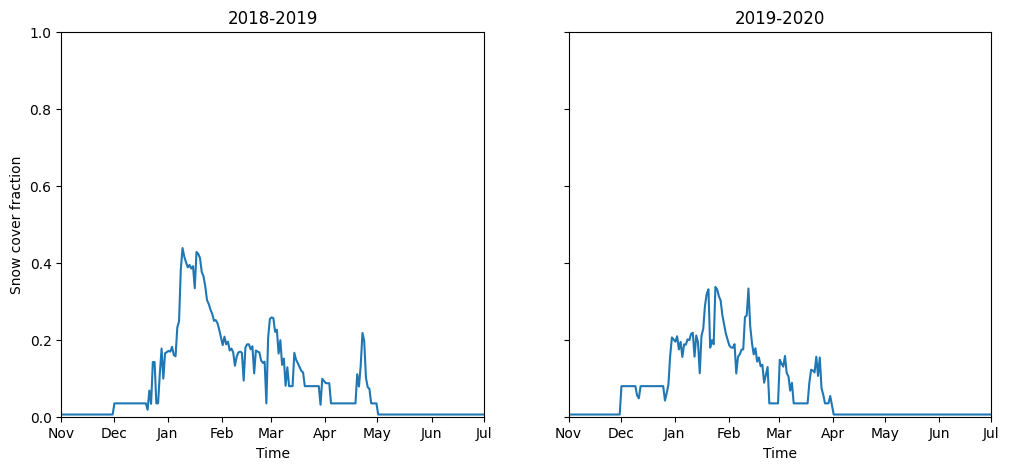

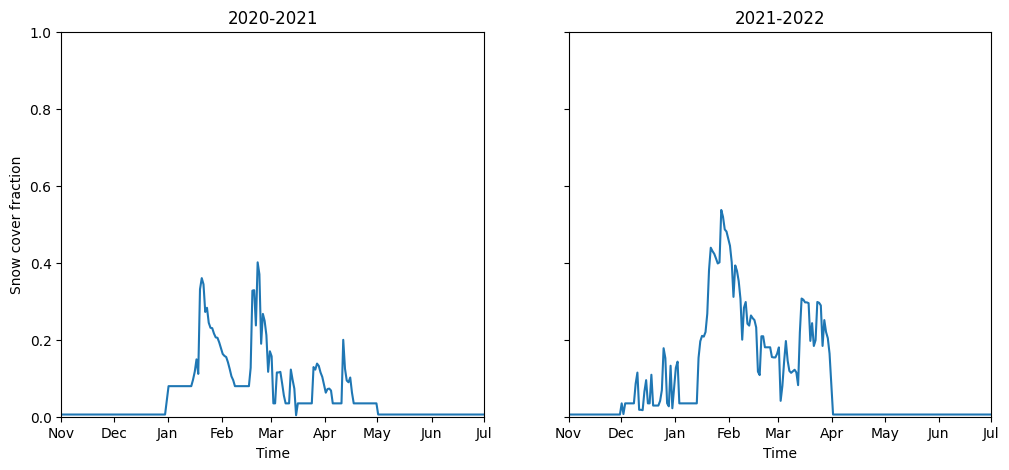

In [17]:
for year in range(1992,2022,2):
    plotYear(year)

In [18]:
years = range(1993,2023)

def reshapeDowy(series):
    tmpList = list()
    for y in years:
        ix = np.logical_and(datesClim >= np.datetime64(date(y,11,1)), datesClim < np.datetime64(date(y+1,7,1))) 
        tmpList.append(series.values[ix])
    df = pd.DataFrame(tmpList).transpose()
    df.columns = years
    return df

scfClimDowy = reshapeDowy(scfClim)
datesClimDowy = reshapeDowy(datesClim)
scfClimDowy.index = datesClimDowy.iloc[0:scfClimDowy.shape[0],0]



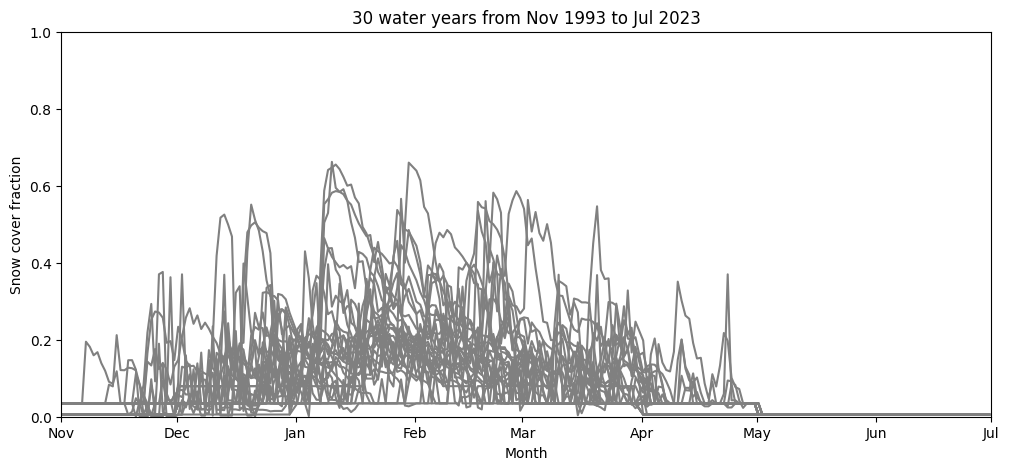

In [19]:
fig = plt.figure(figsize=(12, 5), dpi=100)
ax1 = fig.subplots(ncols=1)

ax1.plot(scfClimDowy, color='grey')
ax1.set_ylabel('Snow cover fraction')
ax1.set_xlabel('Month')
ax1.set_title('{} water years from Nov {} to Jul {}'.format(len(years),years[0],years[-1]+1))
ax1.set_xlim([date(years[0],11,1), date(years[0]+1,7,1)])
ax1.set_ylim([0,1])
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
